In [152]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import keras as krs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from scipy.stats import skew, kurtosis
from scipy.optimize import differential_evolution, minimize
from scipy.fft import fft
from scipy.interpolate import interp1d

In [ ]:
data = pd.read_csv('multi_sensor_simulated_sound_data.csv')

In [ ]:
# Separate the data by sensor
sensor1_data = data[data['Sensor'] == 'Sensor1']
sensor2_data = data[data['Sensor'] == 'Sensor2']
sensor3_data = data[data['Sensor'] == 'Sensor3']
sensor4_data = data[data['Sensor'] == 'Sensor4']

# Combine data for all sensors into a single DataFrame with separate columns for each sensor's amplitude
combined_data = pd.DataFrame({
    'Angle': sensor1_data['Angle'].reset_index(drop=True),  # Use Angle as the reference
    'Sensor1_Amplitude': sensor1_data['Amplitude'].reset_index(drop=True),
    'Sensor2_Amplitude': sensor2_data['Amplitude'].reset_index(drop=True),
    'Sensor3_Amplitude': sensor3_data['Amplitude'].reset_index(drop=True),
    'Sensor4_Amplitude': sensor4_data['Amplitude'].reset_index(drop=True)
})

In [ ]:
# Get unique angles
angles = combined_data['Angle'].unique()

# Plot all sensor data for each angle as subplots
for angle in angles:
    angle_data = combined_data[combined_data['Angle'] == angle]

    # Create a figure with subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
    fig.suptitle(f"Sensor Data for Angle {angle}°", fontsize=16)

    # Sensor 1
    axes[0].plot(angle_data.index, angle_data['Sensor1_Amplitude'], label='Sensor 1', color='b')
    axes[0].set_ylabel("Amplitude")
    axes[0].set_title("Sensor 1")
    axes[0].grid(True)

    # Sensor 2
    axes[1].plot(angle_data.index, angle_data['Sensor2_Amplitude'], label='Sensor 2', color='g')
    axes[1].set_ylabel("Amplitude")
    axes[1].set_title("Sensor 2")
    axes[1].grid(True)

    # Sensor 3
    axes[2].plot(angle_data.index, angle_data['Sensor3_Amplitude'], label='Sensor 3', color='r')
    axes[2].set_ylabel("Amplitude")
    axes[2].set_title("Sensor 3")
    axes[2].grid(True)

    # Sensor 4
    axes[3].plot(angle_data.index, angle_data['Sensor4_Amplitude'], label='Sensor 4', color='m')
    axes[3].set_xlabel("Sample Index")
    axes[3].set_ylabel("Amplitude")
    axes[3].set_title("Sensor 4")
    axes[3].grid(True)

    # Adjust layout and show
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [96]:
combined_data
csv_data = combined_data.to_csv('combined_data.csv', index=False)
combined_data.shape

(1543500, 5)

In [97]:
# Function to calculate THD
def calculate_thd(signal):
    fft_spectrum = np.abs(fft(signal))
    fundamental = fft_spectrum[1]  # Assuming the fundamental is at index 1
    harmonics = np.sum(fft_spectrum[2:])  # Sum of all higher-order harmonics
    thd = harmonics / fundamental if fundamental != 0 else 0
    return thd

# Function to calculate SNR
def calculate_snr(signal, noise_level=1e-10):
    signal_power = np.mean(np.square(signal))
    noise_power = noise_level
    snr = 10 * np.log10(signal_power / noise_power) if noise_power != 0 else 0
    return snr

# Function to calculate SPL
def calculate_spl(signal, reference_pressure=20e-6):
    rms = np.sqrt(np.mean(np.square(signal)))
    spl = 20 * np.log10(rms / reference_pressure) if reference_pressure != 0 else 0
    return spl

# Function to extract features from a signal
def extract_features(signal):
    # Time-domain features
    mean = np.mean(signal)
    variance = np.var(signal)
    std_dev = np.std(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    crest_factor = np.max(np.abs(signal)) / np.sqrt(np.mean(np.square(signal))) if np.mean(np.square(signal)) > 0 else 0
    dynamic_range = np.max(signal) - np.min(signal)
    
    # Frequency-domain features
    fft_spectrum = np.abs(fft(signal))
    dominant_freq = np.argmax(fft_spectrum[:len(fft_spectrum)//2])  # Dominant frequency
    spectral_flatness = np.exp(np.mean(np.log(fft_spectrum + 1e-10))) / np.mean(fft_spectrum + 1e-10)
    
    # Audio metrics
    thd = calculate_thd(signal)
    snr = calculate_snr(signal)
    spl = calculate_spl(signal)
    
    return [
        mean, variance, std_dev, skewness, kurt,
        crest_factor, dynamic_range, dominant_freq, spectral_flatness,
        thd, snr, spl
    ]

# Function to extract features with sliding 1 ms windows
def extract_features_with_1ms_window(signal, window_size=44, step_size=44):
    features = []
    for start in range(0, len(signal) - window_size + 1, step_size):
        window = signal[start:start + window_size]
        features.append(extract_features(window))
    return features

In [98]:
# Load combined_data
combined_data = pd.read_csv('combined_data.csv')

# Placeholder for segmented feature data
segmented_feature_data_1ms = []

# Process each angle
for angle in combined_data['Angle'].unique():
    # Filter rows corresponding to the current angle
    angle_data = combined_data[combined_data['Angle'] == angle]
    
    # Extract full signals for each sensor
    sensor1_signal = angle_data['Sensor1_Amplitude'].values
    sensor2_signal = angle_data['Sensor2_Amplitude'].values
    sensor3_signal = angle_data['Sensor3_Amplitude'].values
    sensor4_signal = angle_data['Sensor4_Amplitude'].values

    # Perform windowed feature extraction for each sensor
    sensor1_features = extract_features_with_1ms_window(sensor1_signal)
    sensor2_features = extract_features_with_1ms_window(sensor2_signal)
    sensor3_features = extract_features_with_1ms_window(sensor3_signal)
    sensor4_features = extract_features_with_1ms_window(sensor4_signal)
    
    # Combine features for all sensors, keeping the angle as the label
    for i in range(len(sensor1_features)):
        combined_features = (
            sensor1_features[i] +
            sensor2_features[i] +
            sensor3_features[i] +
            sensor4_features[i] +
            [angle]
        )
        segmented_feature_data_1ms.append(combined_features)

In [99]:
columns_1ms = (
    [f"Sensor1_{feat}" for feat in [
        'Mean', 'Variance', 'StdDev', 'Skewness', 'Kurtosis', 
        'CrestFactor', 'DynamicRange', 'DominantFreq', 'SpectralFlatness',
        'THD', 'SNR', 'SPL'
    ]] +
    [f"Sensor2_{feat}" for feat in [
        'Mean', 'Variance', 'StdDev', 'Skewness', 'Kurtosis', 
        'CrestFactor', 'DynamicRange', 'DominantFreq', 'SpectralFlatness',
        'THD', 'SNR', 'SPL'
    ]] +
    [f"Sensor3_{feat}" for feat in [
        'Mean', 'Variance', 'StdDev', 'Skewness', 'Kurtosis', 
        'CrestFactor', 'DynamicRange', 'DominantFreq', 'SpectralFlatness',
        'THD', 'SNR', 'SPL'
    ]] +
    [f"Sensor4_{feat}" for feat in [
        'Mean', 'Variance', 'StdDev', 'Skewness', 'Kurtosis', 
        'CrestFactor', 'DynamicRange', 'DominantFreq', 'SpectralFlatness',
        'THD', 'SNR', 'SPL'
    ]] +
    ['Angle']
)

In [100]:
# Create a DataFrame from the segmented features
segmented_feature_df_1ms = pd.DataFrame(segmented_feature_data_1ms, columns=columns_1ms)

In [101]:
segmented_feature_df_1ms
feature_data = segmented_feature_df_1ms
feature_data.shape
feature_data.to_csv('feature_data.csv', index=False)

In [102]:
feature_data

,Sensor1_Mean,Sensor1_Variance,Sensor1_StdDev,Sensor1_Skewness,Sensor1_Kurtosis,Sensor1_CrestFactor,Sensor1_DynamicRange,Sensor1_DominantFreq,Sensor1_SpectralFlatness,Sensor1_THD,...,Sensor4_Skewness,Sensor4_Kurtosis,Sensor4_CrestFactor,Sensor4_DynamicRange,Sensor4_DominantFreq,Sensor4_SpectralFlatness,Sensor4_THD,Sensor4_SNR,Sensor4_SPL,Angle
0,22.916604,0.189128,0.434888,-0.043250,-0.985135,1.029344,1.560824,0,0.039116,4.678676,...,0.241506,-0.573108,1.034090,3.836430,0,0.044358,4.002310,132.837570,126.816970,-90
1,22.115065,1.082562,1.040463,0.150727,-1.202175,1.078760,3.400281,0,0.073266,4.004191,...,0.154290,-1.724536,1.031162,2.574860,0,0.055473,4.726039,132.411441,126.390841,-90
2,22.897136,0.142579,0.377596,0.573618,-0.637084,1.037283,1.364838,0,0.029895,5.414831,...,-0.111280,-0.982675,1.031868,2.508316,0,0.016791,2.769499,132.389377,126.368777,-90
3,25.384261,8.483320,2.912614,0.770975,-0.785205,1.231356,9.153528,0,0.240340,5.833490,...,0.445557,-1.045067,1.013310,1.265053,0,0.016568,8.229887,132.135685,126.115086,-90
4,37.071854,11.116756,3.334180,0.107236,-1.185615,1.152274,11.023384,0,0.226133,6.756456,...,0.470662,-1.324249,1.054050,6.002784,0,0.121156,5.337019,132.951057,126.930457,-90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35072,-18.071807,0.930834,0.964797,-0.560016,-0.461844,1.131529,3.806254,0,0.132827,4.664318,...,-0.333423,-1.329982,1.305647,9.814831,0,0.326081,5.741055,125.447360,119.426760,90
35073,-14.689087,4.046966,2.011707,-0.063893,-1.588994,1.188049,5.956837,0,0.274667,5.419607,...,-0.044274,-1.529806,1.237070,5.590709,0,0.310807,5.726770,121.338031,115.317431,90
35074,-8.786245,1.932959,1.390309,-0.395691,-0.890966,1.315315,4.948211,0,0.219962,3.829124,...,0.162129,-1.436258,1.707778,14.287495,1,0.662847,5.846180,114.258395,108.237795,90
35075,-10.260229,0.361248,0.601040,0.802551,-0.169879,1.086968,2.222180,0,0.124288,9.536536,...,-0.128416,-1.362827,1.328323,10.537545,0,0.425637,6.057947,121.737209,115.716609,90


In [103]:
# Separate features (X) and target (y)
X = feature_data.drop(columns=['Angle']).values  # Drop 'Angle' to get the input features
y = feature_data['Angle'].values  # Target values (angles)

# Display the shapes of X and y
print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")

Shape of X (features): (35077, 48)
Shape of y (target): (35077,)


In [104]:
# Normalize features
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()
X_norm = input_scaler.fit_transform(X)
y_norm = output_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

In [105]:
def weighted_mse(y_true, y_pred):
    weights = 1 + 0.1 * K.abs(y_true)  # Add more weight to extreme angles
    return K.mean(weights * K.square(y_true - y_pred))

# Build the improved DNN model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256), BatchNormalization(), LeakyReLU(negative_slope=0.01), Dropout(0.3),
    Dense(128), BatchNormalization(), LeakyReLU(negative_slope=0.01), Dropout(0.3),
    Dense(64), BatchNormalization(), LeakyReLU(negative_slope=0.01), Dropout(0.2),
    Dense(32), LeakyReLU(negative_slope=0.01),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_mse, metrics=['mae'])

# Add callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    min_delta=0.001,         # Minimum improvement threshold
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,              # Reduce learning rate by a factor of 0.5
    patience=5,             # Wait 5 epochs before reducing the learning rate
    min_lr=1e-6,             # Minimum learning rate
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,  # Increased epochs to allow learning rate adjustments
    batch_size=128,  # Smaller batch size for better generalization
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/300
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2657 - mae: 0.3742 - val_loss: 0.1274 - val_mae: 0.2973 - learning_rate: 0.0010
Epoch 2/300
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0791 - mae: 0.2074 - val_loss: 0.0669 - val_mae: 0.2091 - learning_rate: 0.0010
Epoch 3/300
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0585 - mae: 0.1727 - val_loss: 0.0325 - val_mae: 0.1261 - learning_rate: 0.0010
Epoch 4/300
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0471 - mae: 0.1502 - val_loss: 0.0246 - val_mae: 0.1012 - learning_rate: 0.0010
Epoch 5/300
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0394 - mae: 0.1338 - val_loss: 0.0237 - val_mae: 0.0989 - learning_rate: 0.0010
Epoch 6/300
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0358 - mae: 0.1237 - val_loss: 0.0219 - val_mae: 0.0935 - learning_rate: 0.0010
Epoch 7/300
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0314 - mae: 0.1135 - val_loss: 0.0191 - val_mae: 0.0725 - learning_rate: 0.0010

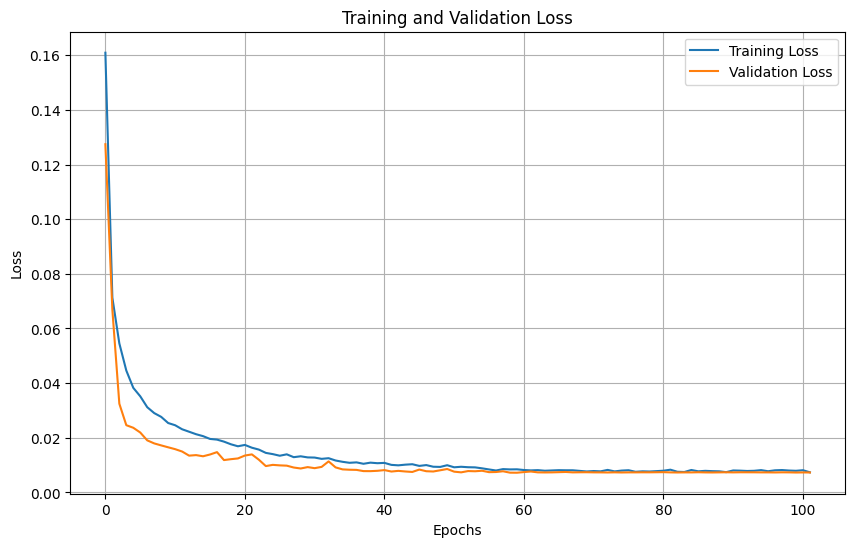

In [106]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Mean Absolute Error (MAE): {mae}")

# Make predictions
y_pred_norm = model.predict(X_test)
y_pred = output_scaler.inverse_transform(y_pred_norm).flatten()

Test Mean Absolute Error (MAE): 0.024105696007609367
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [108]:
y_test = output_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test.shape, y_pred.shape

((7016,), (7016,))

In [111]:
# Calculate evaluation metrics on the original scale
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}%")

Mean Absolute Error (MAE): 4.34
Mean Squared Error (MSE): 269.18
Root Mean Squared Error (RMSE): 16.41
R-squared (R²): 92.57%


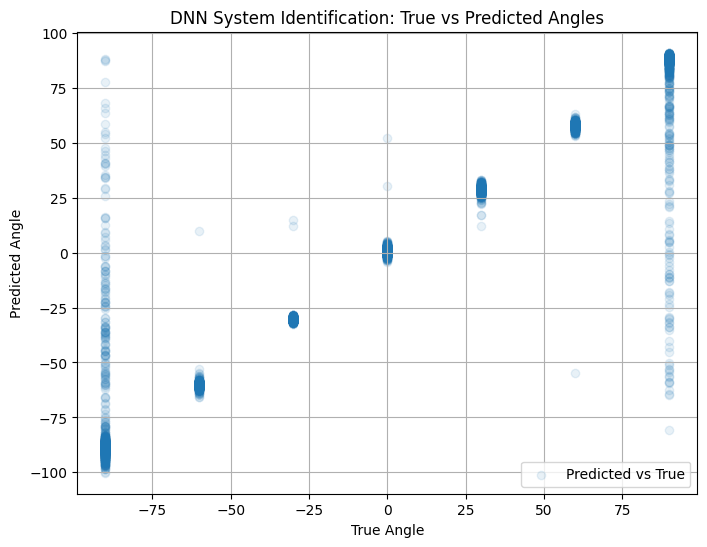

In [110]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1, label='Predicted vs True')
plt.xlabel("True Angle")
plt.ylabel("Predicted Angle")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Angles")
plt.grid(True)
plt.show()

In [ ]:
# Define all features to interpolate
features = feature_data.columns.difference(['Angle'])  # All columns except 'Angle'

# Define existing and new angles
existing_angles = [-90, -60, -30, 0, 30, 60, 90]
new_angles = np.arange(-90, 91, 5)  # All angles with step of 5 degrees

# Placeholder for all interpolated data
all_interpolated_data = []

# Loop through each feature
for feature in features:
    # Extract rows for each existing angle
    angle_grouped_data = {
        angle: feature_data[feature_data['Angle'] == angle][feature].values
        for angle in existing_angles
    }

    # Get the number of rows for interpolation
    rows_per_angle = min(len(angle_grouped_data[angle]) for angle in existing_angles)

    # Interpolate for each row
    for row_idx in range(rows_per_angle):
        # Extract row values for each angle
        row_values = [angle_grouped_data[angle][row_idx] for angle in existing_angles]

        # Create interpolation function
        interp_func = interp1d(
            existing_angles, row_values, kind='cubic', fill_value="extrapolate"
        )

        # Interpolate for new angles
        interpolated_values = interp_func(new_angles)

        # Append the interpolated values for each feature
        for angle, value in zip(new_angles, interpolated_values):
            all_interpolated_data.append({
                'Angle': angle,
                'Row_Index': row_idx,
                feature: value
            })

# Convert all interpolated data to DataFrame
interpolated_all_features_df = pd.DataFrame(all_interpolated_data)

# Merge interpolated data for all features
final_interpolated_df = interpolated_all_features_df.pivot_table(
    index=['Angle', 'Row_Index'], aggfunc='first'
).reset_index()

# Sort by Angle and Row_Index
final_interpolated_df = final_interpolated_df.sort_values(by=['Angle', 'Row_Index']).reset_index(drop=True)
final_interpolated_df

,Angle,Row_Index,Sensor1_CrestFactor,Sensor1_DominantFreq,Sensor1_DynamicRange,Sensor1_Kurtosis,Sensor1_Mean,Sensor1_SNR,Sensor1_SPL,Sensor1_Skewness,...,Sensor4_DynamicRange,Sensor4_Kurtosis,Sensor4_Mean,Sensor4_SNR,Sensor4_SPL,Sensor4_Skewness,Sensor4_SpectralFlatness,Sensor4_StdDev,Sensor4_THD,Sensor4_Variance
0,-90,0,1.029344,0.0,1.560824,-0.985135,22.916604,127.204569,121.183969,-0.043250,...,3.836430,-0.573108,-43.829639,132.837570,126.816970,0.241506,0.044358,0.989274,4.002310,0.978663
1,-90,1,1.078760,0.0,3.400281,-1.202175,22.115065,126.903367,120.882767,0.150727,...,2.574860,-1.724536,-41.732698,132.411441,126.390841,0.154290,0.055473,0.875646,4.726039,0.766755
2,-90,2,1.037283,0.0,1.364838,-0.637084,22.897136,127.196804,121.176204,0.573618,...,2.508316,-0.982675,-41.629446,132.389377,126.368777,-0.111280,0.016791,0.737985,2.769499,0.544621
3,-90,3,1.231356,0.0,9.153528,-0.785205,25.384261,128.148094,122.127494,0.770975,...,1.265053,-1.045067,-40.436044,132.135685,126.115086,0.445557,0.016568,0.342890,8.229887,0.117573
4,-90,4,1.152274,0.0,11.023384,-1.185615,37.071854,131.415874,125.395275,0.107236,...,6.002784,-1.324249,-44.361937,132.951057,126.930457,0.470662,0.121156,2.218443,5.337019,4.921489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185402,90,5006,1.131529,0.0,3.806254,-0.461844,-18.071807,125.152392,119.131792,-0.560016,...,9.814831,-1.329982,-18.452449,125.447360,119.426760,-0.333423,0.326081,3.169516,5.741055,10.045833
185403,90,5007,1.188049,0.0,5.956837,-1.588994,-14.689087,123.420598,117.399998,-0.063893,...,5.590709,-1.529806,-11.530929,121.338031,115.317431,-0.044274,0.310807,1.766476,5.726770,3.120436
185404,90,5008,1.315315,0.0,4.948211,-0.890966,-8.786245,118.983470,112.962870,-0.395691,...,14.287495,-1.436258,-2.149261,114.258395,108.237795,0.162129,0.662847,4.694615,5.846180,22.039410
185405,90,5009,1.086968,0.0,2.222180,-0.169879,-10.260229,120.238019,114.217419,0.802551,...,10.537545,-1.362827,11.755232,121.737209,115.716609,-0.128416,0.425637,3.316330,6.057947,10.998048


In [ ]:
final_interpolated_df = final_interpolated_df.drop(columns=['Row_Index'])
final_interpolated_df.to_csv('final_interpolated_df.csv', index=False)

In [147]:
# Filter the interpolated data for angles that are not in existing_angles
missing_angles = final_interpolated_df[~final_interpolated_df['Angle'].isin(existing_angles)]

# Separate features (X) and targets (y) for prediction
X_missing = missing_angles.drop(columns=['Angle']).values  # Features for prediction

# Predict angles using the trained model for missing angles
predicted_angles = model.predict(X_missing)

# Explicitly cast predictions to float64 to match the expected DataFrame column type
predicted_angles = predicted_angles.astype('float64')

# Replace the 'Angle' column for missing angles with predicted values
missing_angles.loc[:, 'Angle'] = predicted_angles

# Combine with the existing angles
final_combined_df = pd.concat(
    [final_interpolated_df[final_interpolated_df['Angle'].isin(existing_angles)], missing_angles],
    ignore_index=True
)

# Sort by Angle and Row_Index for consistency
final_combined_df = final_combined_df.sort_values(by=['Angle']).reset_index(drop=True)

4698/4698 ━━━━━━━━━━━━━━━━━━━━ 4s 900us/step


C:\Users\Acer\AppData\Local\Temp\ipykernel_24724\478000002.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 52.81842804  50.89702606  49.55246735 ...  14.97525787  68.2952652
 -67.5550766 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  missing_angles.loc[:, 'Angle'] = predicted_angles


In [148]:
final_combined_df

,Angle,Sensor1_CrestFactor,Sensor1_DominantFreq,Sensor1_DynamicRange,Sensor1_Kurtosis,Sensor1_Mean,Sensor1_SNR,Sensor1_SPL,Sensor1_Skewness,Sensor1_SpectralFlatness,...,Sensor4_DynamicRange,Sensor4_Kurtosis,Sensor4_Mean,Sensor4_SNR,Sensor4_SPL,Sensor4_Skewness,Sensor4_SpectralFlatness,Sensor4_StdDev,Sensor4_THD,Sensor4_Variance
0,-1001.326416,1.374596,0.000000,443.909495,-0.732164,-133.337099,149.534199,143.513599,0.539400,0.481673,...,349.751565,-0.937720,-257.517690,148.238828,142.218228,0.557989,0.445900,108.056587,5.070904,12288.204950
1,-997.785400,1.373302,0.000000,429.613077,-0.663898,-113.152634,149.062509,143.041909,0.553310,0.475890,...,349.139468,-0.809879,-279.028402,149.227193,143.206593,0.624416,0.430826,107.525295,5.218369,12111.654362
2,-994.904541,1.346976,0.000000,425.147269,-0.563923,118.121677,149.772077,143.751477,-0.581417,0.453056,...,351.200812,-0.698246,278.090016,148.870920,142.850320,-0.693472,0.454995,107.805462,5.403384,11909.497486
3,-994.686035,1.372607,0.000000,421.098575,-0.575695,-73.302718,148.455638,142.435039,0.575681,0.476253,...,343.629956,-0.722582,-314.857097,150.097346,144.076746,0.685390,0.417296,105.730691,5.295593,11523.047360
4,-993.918213,1.366145,0.000000,428.138379,-0.629645,-86.162468,149.041376,143.020776,0.556880,0.475374,...,340.527084,-0.756752,-296.223911,149.455309,143.434709,0.661593,0.427161,104.753566,5.253132,11325.932997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185402,2219.664307,1.622905,0.833333,810.728605,-1.080447,-124.493797,149.953219,143.932619,0.212450,0.634446,...,877.131793,-1.291943,15.193245,149.554453,143.533853,-0.003043,0.686037,274.889076,6.300593,75575.364534
185403,2219.890869,1.558728,0.833333,807.305329,-1.087899,92.739667,149.971917,143.951317,-0.209814,0.583078,...,879.523450,-1.288890,20.671107,149.680547,143.659947,0.004351,0.678902,275.178169,6.313760,75726.921074
185404,2225.843994,1.569706,0.833333,805.867481,-1.094688,93.861423,149.762102,143.741502,-0.167366,0.640614,...,879.714592,-1.286176,-60.110500,149.566812,143.546212,0.060745,0.668731,275.781708,6.294893,76153.802245
185405,2230.535400,1.642038,0.833333,809.714984,-1.085162,125.493316,149.917027,143.896427,-0.195897,0.639211,...,882.757841,-1.287502,-58.495276,149.487649,143.467049,0.038012,0.679698,276.425726,6.307109,76444.191338


In [ ]:
# y_pred_interpolated_data = output_scaler.inverse_transform(y_pred_interpolated_data_norm).flatten()

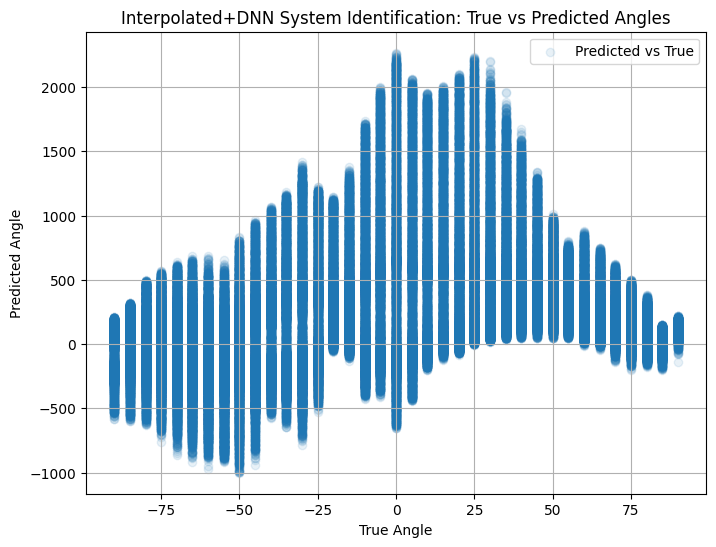

In [142]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_interpolated_data, y_pred_interpolated_data, alpha=0.1, label='Predicted vs True')
plt.xlabel("True Angle")
plt.ylabel("Predicted Angle")
plt.legend()
plt.title("Interpolated+DNN System Identification: True vs Predicted Angles")
plt.grid(True)
plt.show()

In [154]:
print("TensorFlow version:", tf.__version__)
print("Keras version (from tensorflow.keras):", keras.__version__)
print("Standalone Keras version:", krs.__version__)

TensorFlow version: 2.18.0
Keras version (from tensorflow.keras): 3.6.0
Standalone Keras version: 3.6.0
